<a href="https://colab.research.google.com/github/mlbarba/sharing-github/blob/main/W3_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training a Neural Network

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
retention = pd.read_csv(io.BytesIO(uploaded['Retention.csv']))

In [ ]:
# Data Processing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay

In [ ]:
#The file Retention.csv contains data of 3000 customers to be used to classify a cell phone customer as a churner or not.
retention = pd.read_csv("Retention.csv")
retention.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,62,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,45,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57,3.10,6.6
4,0,75,0,0,0.0,3,166.7,113,41,7.42,10.1


# Feature and target selection

In [ ]:
#Features data: select all columns except 'Churn'
X = retention.loc[:, retention.columns!='Churn']

#Response/target data
Y = retention[["Churn"]]

# Split data into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.25,    # hold out 25% of data for testing
                                                    random_state=123) # set for reproducibility

In [ ]:
#Scaling data to the range of 0 to 1 using min/max normalization
scaler = MinMaxScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

## Model fitting and prediction

In [ ]:
#Initialize and fit the algorithm to the training data
# max-iter: Maximum number of iterations. The solver iterates until convergence (determined by ‘tol’) or this number of iterations.
# default architecture is one hidden layer with 100 neurons
NNclf = MLPClassifier(max_iter=500,
                      random_state=0)

#Change the shape of label column to array
NNclf.fit(X_train_s, np.ravel(Y_train))

MLPClassifier(max_iter=500, random_state=0)

In [ ]:
# Make predictions using the model and the testing data
Y_pred = NNclf.predict(X_test_s)

# Get accuracy measures
print('Accuracy:',accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))
pd.DataFrame(confusion_matrix(Y_test, Y_pred),
            columns=["Predicted negative", "Predicted positive"],
            index=["Actual negative","Actual positive"])

Accuracy: 0.9146666666666666
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       626
           1       0.86      0.58      0.69       124

    accuracy                           0.91       750
   macro avg       0.89      0.78      0.82       750
weighted avg       0.91      0.91      0.91       750



,Predicted negative,Predicted positive
Actual negative,614,12
Actual positive,52,72


In [ ]:
# hidden_layer_sizes: The ith element represents the number of neurons in the ith hidden layer (default=(100,))
# activation: Activation function for the hidden layer. Options: 'identity','logistic','tanh','relu' (default='relu')
# solver: The solver for weight optimization. (default='adam')
# alpha: Strength of the L2 regularization term. (default=0.0001)
# learning_rate_init: The initial learning rate used. It controls the step-size in updating the weights.(default=0.001)
param_grid = {
    'hidden_layer_sizes': [(10,10),(10,10,10)],
    'max_iter': [1500],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate_init': [0.001,0.01],
    'random_state': [0]}

# Use grid search to find the best hyperparameters
# n_jobs: Number of jobs to run in parallel. -1 means using all processors (warning:-1 will slow down your computer). (default=1)
grid_search = GridSearchCV(NNclf,
                           param_grid,
                           n_jobs=-1,
                           cv=5)

# Fit the grid search object to the data
grid_search.fit(X_train_s, np.ravel(Y_train))

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=500, random_state=0),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 10), (10, 10, 10)],
                         'learning_rate_init': [0.001, 0.01],
                         'max_iter': [1500], 'random_state': [0],
                         'solver': ['sgd', 'adam']})

In [ ]:
# Obtain and save the values of the best set of hyperparamters
#(full details of cross validation are saved as cv_results_)
best_nn = grid_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  grid_search.best_params_)

Best hyperparameters: {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (10, 10, 10), 'learning_rate_init': 0.01, 'max_iter': 1500, 'random_state': 0, 'solver': 'adam'}


In [ ]:
# Generate predictions with the best model
Y_pred_tuned = best_nn.predict(X_test_s)

# Get accuracy measures
print(classification_report(Y_test, Y_pred_tuned))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       626
           1       0.72      0.63      0.67       124

    accuracy                           0.90       750
   macro avg       0.82      0.79      0.80       750
weighted avg       0.89      0.90      0.89       750



## Model comparison

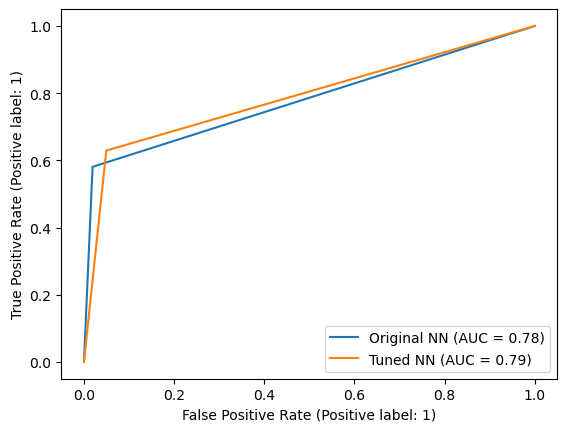

In [ ]:
#Compare ROC curves for the two classifiers: the original random forest versus the tuned random forest
disp = RocCurveDisplay.from_predictions(Y_test,Y_pred,name="Original NN")
RocCurveDisplay.from_predictions(Y_test,Y_pred_tuned,name="Tuned NN",ax=disp.ax_);